In [67]:
import sys
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import minimize, Bounds

In [68]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def dh2v(dh):
    logdh = np.log(dh)
    logv = (logdh-1.647)/-0.4619
    
    v = np.exp(logv)
    return v

def v2dh(v):
    logdh = -0.4619*np.log(v)+1.647
    
    dh = np.exp(logdh)
    return dh

def v2dh_noised(v):
    mod_noise = np.random.rand(2)-0.9
    coeff1_noised = mod_noise[0]*0.05+0.4619
    coeff2_noised = mod_noise[0]*0.5+1.647
    logdh = -coeff1_noised*np.log(v)+coeff2_noised
    
    dh = np.exp(logdh)
    return dh

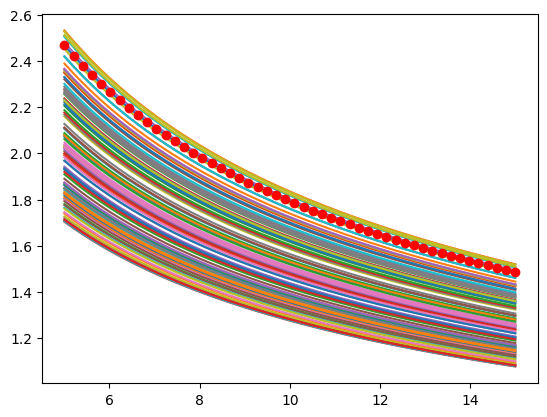

In [69]:
v = np.linspace(5, 15)

for i in range(100): plt.plot(v,v2dh_noised(v))
plt.plot(v, v2dh(v), 'ro')
plt.show()

In [70]:
x = np.linspace(0,100,100)
noise = np.random.rand(100)*100


here


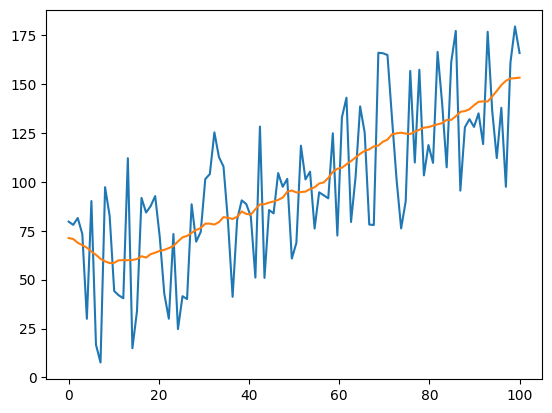

In [71]:
y = x+noise
y = savgol_filter(y, int(len(y)/2), 3, mode='nearest')

plt.plot(x,x+noise)
plt.plot(x,y)

print("here")
plt.show()

In [72]:
print("starting")
num_layers = 80
part_len = 50 #mm
v_min = 5
max_dH = v2dh(v_min)
v_max = 15
min_dH = v2dh(v_max)
points_per_layer = 100

layer_angle = np.arcsin((max_dH-min_dH)/part_len)
rot_point = max_dH/np.tan(layer_angle)-part_len/2
print(np.rad2deg(layer_angle))
print(rot_point)
print(max_dH)
print(min_dH)
print(np.rad2deg(num_layers*layer_angle))

starting
1.1257976619508032
100.6131657840027
2.468475190539253
1.4860946104132609
90.06381295606425


Final Height Error:  22.250196155958545


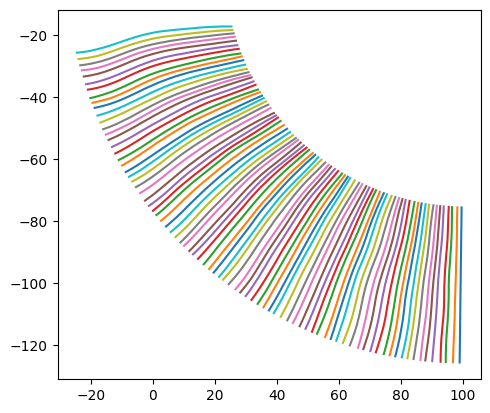

In [73]:


np.random.seed(1234)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 6, mode='nearest')
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)
for i in range(1,num_layers):
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_nom)+curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
print("Final Height Error: ", np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])))
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
plt.show()

In [74]:
def v_opt(v_next, v_prev, h_err, h_targ, lam):
    return norm(h_targ+h_err-v2dh(v_next), 2)**2

[ 3.47260462  3.5041406   3.53608243  3.56846458  3.60124786  3.63445306
  3.66817375  3.70231792  3.73688549  3.77193627  3.80747879  3.84349813
  3.88000574  3.91702528  3.95456843  3.99263763  4.03123639  4.07037327
  4.11006009  4.15030906  4.19113157  4.23253826  4.27453968  4.31714672
  4.36037074  4.40422356  4.44871732  4.4938644   4.5396775   4.58616958
  4.63335395  4.68124425  4.72985447  4.77919894  4.82929234  4.88014959
  4.93178571  4.98421569  5.0374545   5.09151717  5.1464193   5.20216533
  5.25879474  5.31632471  5.37478045  5.43418622  5.49456317  5.55592819
  5.61829429  5.68167248  5.74607442  5.81151528  5.87801567  5.94560249
  6.01430833  6.0841696   6.15522392  6.22750723  6.30105155  6.37588383
  6.45202608  6.52949695  6.60831426  6.68849778  6.77007192  6.8530673
  6.93752135  7.02347747  7.11098333  7.2000883   7.29084094  7.38328682
  7.47746709  7.57341816  7.67117253  7.77076062  7.87221312  7.97556394
  8.08085254  8.18812602  8.29743989  8.4088579   8.

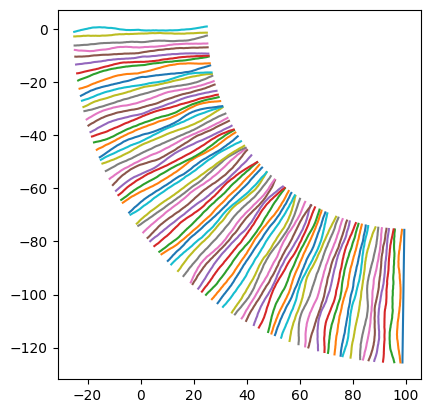

In [77]:
np.random.seed(1)

vel_prev = vel_nom
lam = 0.01
#constraints
bounds = Bounds(3, 17)

def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*5
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 6, mode='nearest')
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_profile = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_profile)
for i in range(1,num_layers):
    try:
        new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
        curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T

        # measure and correct
        height_vals_prev = curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]
        height_err = 0-height_vals_prev
        opt_result=minimize(v_opt, vel_nom, (vel_prev, height_err, height_profile, lam), bounds=bounds,
                            options = {'maxfun':100000})
        if not opt_result.success: 
            print(opt_result)
            raise ValueError(opt_result.message)
        vel_profile = opt_result.x
        print(vel_profile)
        height_target = height_profile+height_err

        curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
        curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_profile)+height_vals_prev)

        vel_prev = vel_profile
    except:
        break
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
print("Final Height Error: ", np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])))
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
plt.show()